# 9장. 지리 정보 분석 (2) 행정구역별 데이터 분석 + 블록맵

# 1. 데이터 준비 및 탐색

In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment',  None) # Warning 방지용
import numpy as np

data = pd.read_csv('data/공공보건의료기관현황.csv', index_col=0, encoding='CP949', engine='python')

data.head() #작업내용 확인용 출력

,병원 명,설립형태,근거 법령,관계 행정기관,관계 공공단체,심평원 요양기관번호,종별구분,병상수,소재지 우편번호,주소,홈페이지,대표전화,FAX,비고
연번,,,,,,,,,,,,,,
1,강원도 재활병원,시도립,강원도재활병원설치및운영에관한조례,강원도,해당없음,32200641,병원,165,24227,강원도 춘천시 충열로 142번길 24-16,www.grh.or.kr,033-248-7700,033-248-7723,NaN
2,강원도 삼척의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,보건복지부(강원도),지방의료원,32100060,종합병원,152,25920,강원도 삼척시 오십천로 418,http://ksmc.or.kr,033-572-1141,033-573-8424,NaN
3,강원도 영월의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,보건복지부(강원도),지방의료원,32100078,종합병원,214,26234,강원도 영월군 영월읍 중앙1로 59,http://www.youngwol.org,033-370-9117,033-370-9137,NaN
4,강원도 원주의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,보건복지부(강원도),지방의료원,32100086,종합병원,237,26448,강원도 원주시 서원대로 387(개운동),www.kwmc.or.kr,033-760-4500,033-761-5121,NaN
5,강원도 강릉의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,보건복지부(강원도),지방의료원,32100159,종합병원,137,25535,강원도 강릉시 경강로 2007(남문동 164-1),http://www.gnmc.or.kr,033-646-6910,033-610-1415,NaN


In [2]:
## 주소에서 시도, 군구 정보 분리

addr = pd.DataFrame(data['주소'].apply(lambda v: v.split()[:2]).tolist(),columns=('시도', '군구'))

addr.head()  #작업내용 확인용 출력

,시도,군구
0,강원도,춘천시
1,강원도,삼척시
2,강원도,영월군
3,강원도,원주시
4,강원도,강릉시


## 1) 시도 이름 확인하기

In [3]:
addr['시도'].unique()

array(['강원도', '경기도', '경기', '경남', '창원시', '경상남도', '경상북도', '경산시', '경북',
       '인천광역시', '대구광역시', '전라남도', '대전광역시', '광주광역시', '제주특별자치도', '부산광역시',
       '전라북도', '충북', '서울특별시', '서울시', '부산특별시', '대전시', '충남', '전남', '충청남도',
       '울산광역시', '전북', '천안시', '충청북도'], dtype=object)

### #잘못된 시도 이름 수정 : 창원시, 경산시, 천안시

#### (1) '창원시'를 찾아서 '경상남도 창원시'로 수정

In [4]:
addr[addr['시도'] == '창원시']

,시도,군구
27,창원시,의창구
31,창원시,마산합포구3.15대로


In [5]:
## 표준 행정구역 이름으로 수정 : 창원시-> 경상남도 창원시
addr.iloc[27] = ['경상남도', '창원시']
addr.iloc[31] = ['경상남도', '창원시']

In [6]:
addr.iloc[27]

시도    경상남도
군구     창원시
Name: 27, dtype: object

In [7]:
addr.iloc[31]

시도    경상남도
군구     창원시
Name: 31, dtype: object

#### (2) '경산시'를 찾아서 '경상북도 경산시'로 수정

In [8]:
addr[addr['시도'] == '경산시']

,시도,군구
47,경산시,경안로


In [9]:
addr.iloc[47] = ['경상북도', '경산시']
addr.iloc[47]

시도    경상북도
군구     경산시
Name: 47, dtype: object

#### (3) '천안시'를 찾아서 '충청남도 천안시'로 수정

In [10]:
addr[addr['시도'] == '천안시']

,시도,군구
209,천안시,동남구
210,천안시,동남구


In [11]:
## 표준 행정구역 이름으로 수정 : 천안시-> 충청남도 천안시
addr.iloc[209] = ['충청남도', '천안시']
addr.iloc[210] = ['충청남도', '천안시']

In [12]:
addr.iloc[209]

시도    충청남도
군구     천안시
Name: 209, dtype: object

In [13]:
addr.iloc[210]

시도    충청남도
군구     천안시
Name: 210, dtype: object

In [14]:
# 작업 결과 확인하기
addr['시도'].unique()

array(['강원도', '경기도', '경기', '경남', '경상남도', '경상북도', '경북', '인천광역시', '대구광역시',
       '전라남도', '대전광역시', '광주광역시', '제주특별자치도', '부산광역시', '전라북도', '충북',
       '서울특별시', '서울시', '부산특별시', '대전시', '충남', '전남', '충청남도', '울산광역시', '전북',
       '충청북도'], dtype=object)

### # 시도 이름을 표준이름으로 수정

In [15]:
## 표준 행정구역 이름으로 수정 :  경기 -> 경기도, 경남 -> 경상남도, ...
addr_aliases = {'경기':'경기도', '경남':'경상남도', '경북':'경상북도', '충북':'충청북도', 
                '서울시':'서울특별시', '부산특별시':'부산광역시', '대전시':'대전광역시', 
                '충남':'충청남도', '전남':'전라남도', '전북':'전라북도'}

In [16]:
addr['시도']= addr['시도'].apply(lambda v: addr_aliases.get(v, v))

In [17]:
# 작업 결과 확인하기
addr['시도'].unique()

array(['강원도', '경기도', '경상남도', '경상북도', '인천광역시', '대구광역시', '전라남도', '대전광역시',
       '광주광역시', '제주특별자치도', '부산광역시', '전라북도', '충청북도', '서울특별시', '충청남도',
       '울산광역시'], dtype=object)

## 2) 군구 이름 확인하기 

In [18]:
addr['군구'].unique()

array(['춘천시', '삼척시', '영월군', '원주시', '강릉시', '속초시', '정선군', '수원시', '이천시',
       '안성시', '의정부시', '포천시', '파주시', '용인시', '평택시', '시흥시', '여주시', '남양주시',
       '동두천시', '안산시', '부천시', '통영시', '사천시', '창원시', '김해시', '양산시', '거창군',
       '남해군', '의령군', '포항시', '김천시', '안동시', '울진군', '경주시', '구미시', '영주시',
       '상주시', '문경시', '경산시', '의성군', '청도군', '고령군', '칠곡군', '봉화군', '울릉군',
       '부평구', '북구', '순천시', '대덕구', '태백시', '동해시', '화성시', '광산구', '남구', '중구',
       '아란13길', '서구', '전주시', '진주시', '청주시', '종로구', '성남시', '동구', '화순군',
       '강동구', '사상구', '달서구', '해운대구', '유성구', '가평군', '양주시', '고양시', '홍천군',
       '양구군', '청원군', '계룡시', '논산시', '함평군', '양평군', '수성구', '달성군', '연수구',
       '노원구', '기장군', '공주시', '강북구', '광진구', '나주시', '창녕군', '목포시', '고흥군',
       '연제구', '동매로', '서초구', '은평구', '중랑구', '강남구', '동작구', '동대문구', '양천구',
       '성동구', '송파구', '울주군', '계양구', '옹진군', '보성군', '광양시', '영광군', '무안군',
       '진도군', '강진군', '곡성군', '여수시', '신안군', '장성군', '완주군', '부안군', '정읍시',
       '남원시', '군산시', '고창군', '진안군', '제주시', '서귀포시', '천안시', '보령시', '서산시',
       '서천

### # 잘못된 군구 이름 수정하기 

#### (1) '아란13길' 을 '제주특별자치도'  '제주시'로 수정

In [19]:
addr[addr['군구'] == '아란13길']

,시도,군구
75,제주특별자치도,아란13길


In [20]:
addr.iloc[75] = ['제주특별자치도', '제주시']
addr.iloc[75]

시도    제주특별자치도
군구        제주시
Name: 75, dtype: object

In [21]:
addr['군구'].unique()

array(['춘천시', '삼척시', '영월군', '원주시', '강릉시', '속초시', '정선군', '수원시', '이천시',
       '안성시', '의정부시', '포천시', '파주시', '용인시', '평택시', '시흥시', '여주시', '남양주시',
       '동두천시', '안산시', '부천시', '통영시', '사천시', '창원시', '김해시', '양산시', '거창군',
       '남해군', '의령군', '포항시', '김천시', '안동시', '울진군', '경주시', '구미시', '영주시',
       '상주시', '문경시', '경산시', '의성군', '청도군', '고령군', '칠곡군', '봉화군', '울릉군',
       '부평구', '북구', '순천시', '대덕구', '태백시', '동해시', '화성시', '광산구', '남구', '중구',
       '제주시', '서구', '전주시', '진주시', '청주시', '종로구', '성남시', '동구', '화순군', '강동구',
       '사상구', '달서구', '해운대구', '유성구', '가평군', '양주시', '고양시', '홍천군', '양구군',
       '청원군', '계룡시', '논산시', '함평군', '양평군', '수성구', '달성군', '연수구', '노원구',
       '기장군', '공주시', '강북구', '광진구', '나주시', '창녕군', '목포시', '고흥군', '연제구',
       '동매로', '서초구', '은평구', '중랑구', '강남구', '동작구', '동대문구', '양천구', '성동구',
       '송파구', '울주군', '계양구', '옹진군', '보성군', '광양시', '영광군', '무안군', '진도군',
       '강진군', '곡성군', '여수시', '신안군', '장성군', '완주군', '부안군', '정읍시', '남원시',
       '군산시', '고창군', '진안군', '서귀포시', '천안시', '보령시', '서산시', '서천군', '홍성군',
     

## 3) 행정구역별 공공보건의료기관의 수 구하기

### (1) '시도' 와 '군구' 컬럼 결합하기

In [22]:
addr['시도군구'] = addr.apply(lambda r: r['시도'] + ' ' + r['군구'], axis=1)
addr.head() #작업 확인용 출력

,시도,군구,시도군구
0,강원도,춘천시,강원도 춘천시
1,강원도,삼척시,강원도 삼척시
2,강원도,영월군,강원도 영월군
3,강원도,원주시,강원도 원주시
4,강원도,강릉시,강원도 강릉시


In [23]:
addr['count'] = 0  # 의료기관수 합계를 저장할 컬럼 만들기
addr.head() #작업 확인용 출력

,시도,군구,시도군구,count
0,강원도,춘천시,강원도 춘천시,0
1,강원도,삼척시,강원도 삼척시,0
2,강원도,영월군,강원도 영월군,0
3,강원도,원주시,강원도 원주시,0
4,강원도,강릉시,강원도 강릉시,0


In [24]:
addr.loc[addr['시도군구']=='강원도 춘천시',:]

,시도,군구,시도군구,count
0,강원도,춘천시,강원도 춘천시,0
6,강원도,춘천시,강원도 춘천시,0
69,강원도,춘천시,강원도 춘천시,0
105,강원도,춘천시,강원도 춘천시,0
142,강원도,춘천시,강원도 춘천시,0


### (2) '시도군구' 를 기준으로 그룹을 만들고, 그룹별 의료기관수 합계 구하기

In [25]:
addr_group =pd.DataFrame(addr.groupby(['시도', '군구', '시도군구'], as_index=False).count())
addr_group.head()  #작업 확인용 출력

,시도,군구,시도군구,count
0,강원도,강릉시,강원도 강릉시,4
1,강원도,동해시,강원도 동해시,1
2,강원도,삼척시,강원도 삼척시,1
3,강원도,속초시,강원도 속초시,1
4,강원도,양구군,강원도 양구군,1


### (3) 데이터 병합에 사용할 인덱스 설정하기

In [26]:
addr_group = addr_group.set_index("시도군구")
addr_group.head()   #작업 확인용 출력

,시도,군구,count
시도군구,,,
강원도 강릉시,강원도,강릉시,4
강원도 동해시,강원도,동해시,1
강원도 삼척시,강원도,삼척시,1
강원도 속초시,강원도,속초시,1
강원도 양구군,강원도,양구군,1


## 4) 행정구역 인구수 컬럼 추가하기

####   (1) 행정구역 이름 데이터 불러오기 : 행정구역_시군구_별__성별_인구수_2.xlsx

In [27]:
population = pd.read_excel('data/행정구역_시군구_별__성별_인구수.xlsx')
population.head()    #작업 확인용 출력

,행정구역(시군구)별(1),행정구역(시군구)별(2),총인구수 (명),남자인구수 (명),여자인구수 (명)
0,전국,소계,51583722,25715591,25868131
1,서울특별시,소계,9496887,4607440,4889447
2,서울특별시,종로구,143850,69638,74212
3,서울특별시,중구,122054,59368,62686
4,서울특별시,용산구,222083,106666,115417


In [28]:
population = population.rename(columns = {'행정구역(시군구)별(1)': '시도', 
                                          '행정구역(시군구)별(2)': '군구'}) #컬럼이름 변경
population.head()  #작업 확인용 출력

,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명)
0,전국,소계,51583722,25715591,25868131
1,서울특별시,소계,9496887,4607440,4889447
2,서울특별시,종로구,143850,69638,74212
3,서울특별시,중구,122054,59368,62686
4,서울특별시,용산구,222083,106666,115417


####   (2) 병합에 사용할 공통 컬럼 '시도군구' 추가하기

In [29]:
# '군구' 컬럼에서 공백 제거하기
for element in range(0,len(population)):
    population['군구'][element] = population['군구'][element].strip()
    print(population['군구'][element])  

소계
소계
종로구
중구
용산구
성동구
광진구
동대문구
중랑구
성북구
강북구
도봉구
노원구
은평구
서대문구
마포구
양천구
강서구
구로구
금천구
영등포구
동작구
관악구
서초구
강남구
송파구
강동구
소계
중구
서구
동구
영도구
부산진구
동래구
남구
북구
해운대구
사하구
금정구
강서구
연제구
수영구
사상구
기장군
소계
중구
동구
서구
남구
북구
수성구
달서구
달성군
소계
중구
중구영종출장소
중구용유출장소
동구
미추홀구
연수구
남동구
부평구
계양구
서구
서구검단출장소
강화군
옹진군
소계
동구
서구
남구
북구
광산구
소계
동구
중구
서구
유성구
대덕구
소계
중구
남구
동구
북구
울주군
소계
세종시
소계
수원시
장안구
권선구
팔달구
영통구
성남시
수정구
중원구
분당구
의정부시
안양시
만안구
동안구
부천시
광명시
평택시
송탄출장소
안중출장소
동두천시
안산시
상록구
단원구
고양시
덕양구
일산동구
일산서구
과천시
구리시
남양주시
풍양출장소
오산시
시흥시
군포시
의왕시
하남시
용인시
처인구
기흥구
수지구
파주시
이천시
안성시
김포시
화성시
화성시동부출장소
화성시동탄출장소
광주시
양주시
포천시
여주시
연천군
가평군
양평군
소계
춘천시
원주시
강릉시
동해시
태백시
속초시
삼척시
홍천군
횡성군
영월군
평창군
정선군
철원군
화천군
양구군
인제군
고성군
양양군
소계
청주시
서원구
청원구
상당구
흥덕구
충주시
제천시
보은군
옥천군
영동군
증평군
진천군
괴산군
음성군
단양군
소계
당진시
천안시
동남구
서북구
공주시
보령시
아산시
서산시
논산시
계룡시
금산군
부여군
서천군
청양군
홍성군
예산군
태안군
소계
전주시
완산구
덕진구
전주시효자출장소
군산시
익산시
익산시함열출장소
정읍시
남원시
김제시
완주군
진안군
무주군
장수군
임실군
순창군
고창군
부안군
소계
목포시
여수시
순천시
나주시
광양시
담양군
곡성군
구례군
고흥군
보성군
화순군
장흥군
강진군
해남군
영암군
무안군
함평군
영광군
장성군
완도군
진도군
신안군
소계
포항시
남구
북구
경주시
김천시
안동시
구미시
영주시
영천시
상주시
문경시
경산

In [30]:
# '시도'와 '군구'를 연결하여 '시도군구' 컬럼 추가
population['시도군구']= population.apply(lambda r: r['시도'] + ' ' + r['군구'], axis=1)
population.head()  #작업 확인용 출력

,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명),시도군구
0,전국,소계,51583722,25715591,25868131,전국 소계
1,서울특별시,소계,9496887,4607440,4889447,서울특별시 소계
2,서울특별시,종로구,143850,69638,74212,서울특별시 종로구
3,서울특별시,중구,122054,59368,62686,서울특별시 중구
4,서울특별시,용산구,222083,106666,115417,서울특별시 용산구


##### -  필요없는  '소계' 행 삭제

In [31]:
population = population[population.군구 != '소계']
population.head()  #작업 확인용 출력

,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명),시도군구
2,서울특별시,종로구,143850,69638,74212,서울특별시 종로구
3,서울특별시,중구,122054,59368,62686,서울특별시 중구
4,서울특별시,용산구,222083,106666,115417,서울특별시 용산구
5,서울특별시,성동구,284173,138373,145800,서울특별시 성동구
6,서울특별시,광진구,340062,164091,175971,서울특별시 광진구


####   (3) 병합의 기준이 될 인덱스를 '시도군구'로 설정

In [32]:
population = population.set_index("시도군구")
population.head()  #작업 확인용 출력

,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명)
시도군구,,,,,
서울특별시 종로구,서울특별시,종로구,143850,69638,74212
서울특별시 중구,서울특별시,중구,122054,59368,62686
서울특별시 용산구,서울특별시,용산구,222083,106666,115417
서울특별시 성동구,서울특별시,성동구,284173,138373,145800
서울특별시 광진구,서울특별시,광진구,340062,164091,175971


In [33]:
#addr_population_merge2 = pd.merge(addr_group,population,  how='inner')
#addr_population_merge2.head()   #작업 확인용 출력

In [34]:
#addr_population_merge2.info()

## 5) '의료기관' 데이터프레임과 '시도군구별 인구수' 데이터프레임 병합하기 

In [35]:
addr_population_merge = pd.merge(addr_group,population,  how='inner',  left_index=True, right_index=True)
addr_population_merge.head()   #작업 확인용 출력

,시도_x,군구_x,count,시도_y,군구_y,총인구수 (명),남자인구수 (명),여자인구수 (명)
시도군구,,,,,,,,
강원도 강릉시,강원도,강릉시,4,강원도,강릉시,212414,105385,107029
강원도 동해시,강원도,동해시,1,강원도,동해시,89618,45558,44060
강원도 삼척시,강원도,삼척시,1,강원도,삼척시,64216,32487,31729
강원도 속초시,강원도,속초시,1,강원도,속초시,82725,41037,41688
강원도 양구군,강원도,양구군,1,강원도,양구군,21635,11359,10276


##### -필요한 컬럼만 추출하기

In [36]:
local_MC_Population = addr_population_merge[['시도_x', '군구_x',  'count', '총인구수 (명)']]
local_MC_Population.head()   #작업 확인용 출력  

,시도_x,군구_x,count,총인구수 (명)
시도군구,,,,
강원도 강릉시,강원도,강릉시,4,212414
강원도 동해시,강원도,동해시,1,89618
강원도 삼척시,강원도,삼척시,1,64216
강원도 속초시,강원도,속초시,1,82725
강원도 양구군,강원도,양구군,1,21635


In [37]:
 #컬럼이름 변경
local_MC_Population = local_MC_Population.rename(columns = {'시도_x': '시도', '군구_x': '군구',
                                                            '총인구수 (명)': '인구수' })
local_MC_Population.head()  #작업 확인용 출력

,시도,군구,count,인구수
시도군구,,,,
강원도 강릉시,강원도,강릉시,4,212414
강원도 동해시,강원도,동해시,1,89618
강원도 삼척시,강원도,삼척시,1,64216
강원도 속초시,강원도,속초시,1,82725
강원도 양구군,강원도,양구군,1,21635


## 6) 시도군구의 인구대비 의료기관수 비율 구하기

In [38]:
MC_count = local_MC_Population['count']
local_MC_Population['MC_ratio'] = MC_count.div(local_MC_Population['인구수'], axis=0)*100000
local_MC_Population.head()   #작업 확인용 출력

,시도,군구,count,인구수,MC_ratio
시도군구,,,,,
강원도 강릉시,강원도,강릉시,4,212414,1.883115
강원도 동해시,강원도,동해시,1,89618,1.115847
강원도 삼척시,강원도,삼척시,1,64216,1.557244
강원도 속초시,강원도,속초시,1,82725,1.208824
강원도 양구군,강원도,양구군,1,21635,4.622140


# 2. 분석 모델 구축 및 시각화

##  1) 바 차트 그리기

In [39]:
from matplotlib import pyplot as plt
from matplotlib import rcParams, style
style.use('ggplot')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [40]:
MC_ratio = local_MC_Population[['count']]
MC_ratio

,count
시도군구,
강원도 강릉시,4
강원도 동해시,1
강원도 삼척시,1
강원도 속초시,1
강원도 양구군,1
...,...
충청북도 단양군,1
충청북도 영동군,1
충청북도 제천시,1


####   (1) 행정구역별 공공보건의료기관수에 대한 바 차트 

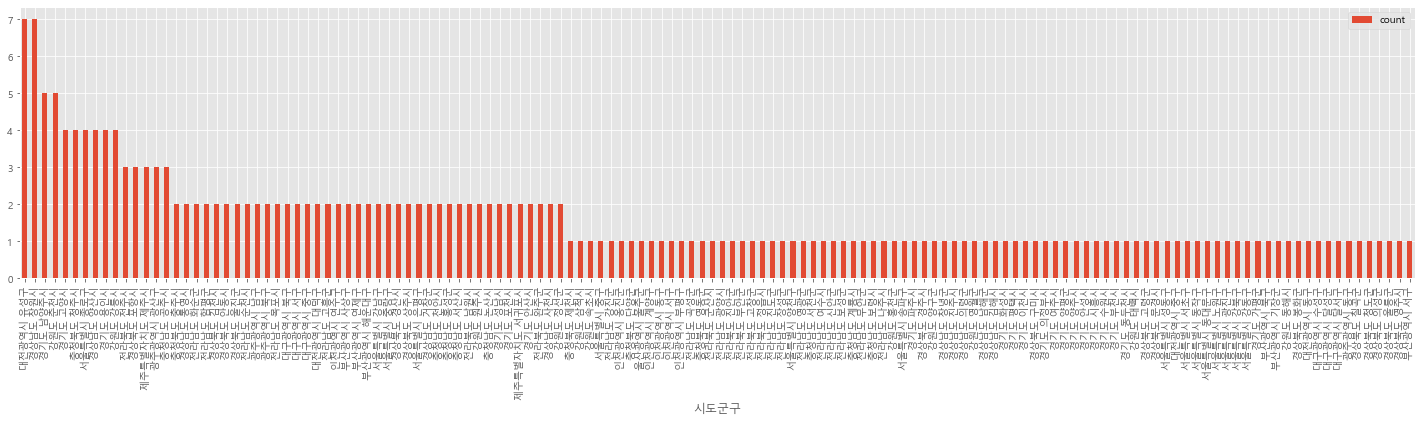

In [41]:
MC_ratio = local_MC_Population[['count']] #데이터프레임, local_MC_Population['count']:Series
MC_ratio = MC_ratio.sort_values('count', ascending = False)
plt.rcParams["figure.figsize"] = (25,5)
MC_ratio.plot(kind='bar', rot=90)
plt.show()

####   (2) 행정구역별 인구수 대비 공공보건의료기관 비율에 대한 바 차트 

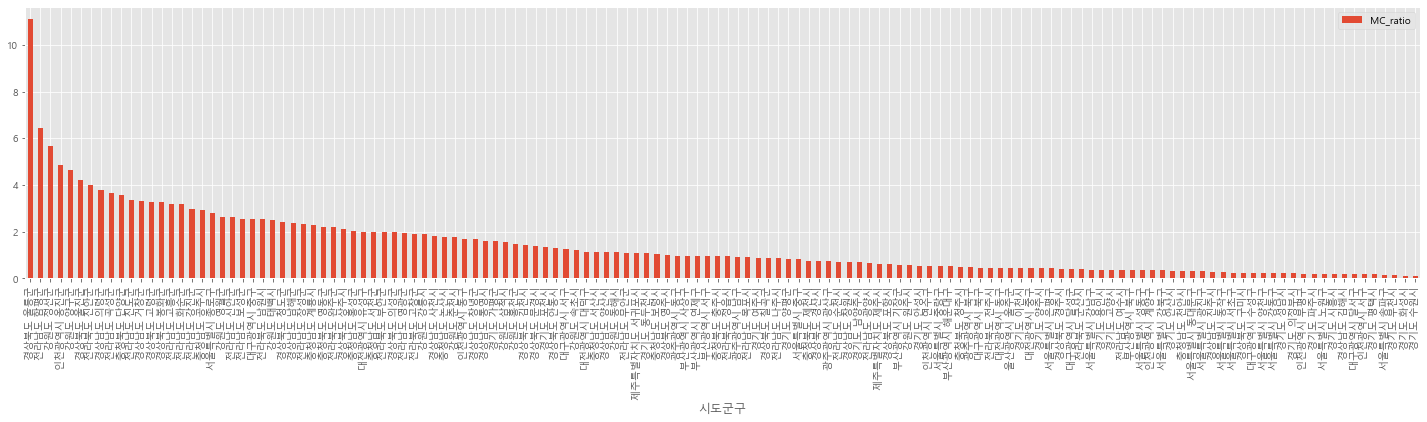

In [42]:
MC_ratio = local_MC_Population[['MC_ratio']]
MC_ratio = MC_ratio.sort_values('MC_ratio', ascending = False)
plt.rcParams["figure.figsize"] = (25,5)
MC_ratio.plot(kind='bar', rot=90)
plt.show()

## 2) 블록맵 시각화

###   (1) 블록맵 데이터 파일 열기

In [43]:
import os
path = os.getcwd() # 현제 작업 디렉토리
#data_draw_korea.csv 대한민국 행정구역 인구수 블록맵 데이터

In [44]:
data_draw_korea = pd.read_csv('data/data_draw_korea.csv', index_col=0, encoding='UTF-8', engine='python')
data_draw_korea.head()   #작업 확인용 출력

,인구수,shortName,x,y,면적,광역시도,행정구역
0,202520,강릉,11,4,1040.07,강원도,강릉시
1,25589,고성(강원),9,0,664.19,강원도,고성군
2,86747,동해,11,5,180.01,강원도,동해시
3,63986,삼척,11,8,1185.80,강원도,삼척시
4,76733,속초,9,1,105.25,강원도,속초시


###   (2) 블록맵 데이터 파일에 '시도군구' 컬럼 만들기

In [45]:
data_draw_korea['시도군구']= data_draw_korea.apply(lambda r: r['광역시도'] + ' ' + r['행정구역'], axis=1)
data_draw_korea.head()  #작업 확인용 출력

,인구수,shortName,x,y,면적,광역시도,행정구역,시도군구
0,202520,강릉,11,4,1040.07,강원도,강릉시,강원도 강릉시
1,25589,고성(강원),9,0,664.19,강원도,고성군,강원도 고성군
2,86747,동해,11,5,180.01,강원도,동해시,강원도 동해시
3,63986,삼척,11,8,1185.80,강원도,삼척시,강원도 삼척시
4,76733,속초,9,1,105.25,강원도,속초시,강원도 속초시


###   (3) 블록맵 데이터에서 병합에 사용할 '시도군구' 컬럼을 인덱스로 설정하기

In [46]:
data_draw_korea = data_draw_korea.set_index("시도군구")
data_draw_korea.head()  #작업 확인용 출력

,인구수,shortName,x,y,면적,광역시도,행정구역
시도군구,,,,,,,
강원도 강릉시,202520,강릉,11,4,1040.07,강원도,강릉시
강원도 고성군,25589,고성(강원),9,0,664.19,강원도,고성군
강원도 동해시,86747,동해,11,5,180.01,강원도,동해시
강원도 삼척시,63986,삼척,11,8,1185.80,강원도,삼척시
강원도 속초시,76733,속초,9,1,105.25,강원도,속초시


###   (4) 블록맵 데이터프레임과 local_MC_Population을 병합하기

In [47]:
data_draw_korea_MC_Population_all = pd.merge(data_draw_korea,local_MC_Population,  how='outer',left_index=True, right_index=True)
data_draw_korea_MC_Population_all.head()

,인구수_x,shortName,x,y,면적,광역시도,행정구역,시도,군구,count,인구수_y,MC_ratio
시도군구,,,,,,,,,,,,
강원도 강릉시,202520,강릉,11,4,1040.07,강원도,강릉시,강원도,강릉시,4.0,212414.0,1.883115
강원도 고성군,25589,고성(강원),9,0,664.19,강원도,고성군,NaN,NaN,NaN,NaN,NaN
강원도 동해시,86747,동해,11,5,180.01,강원도,동해시,강원도,동해시,1.0,89618.0,1.115847
강원도 삼척시,63986,삼척,11,8,1185.80,강원도,삼척시,강원도,삼척시,1.0,64216.0,1.557244
강원도 속초시,76733,속초,9,1,105.25,강원도,속초시,강원도,속초시,1.0,82725.0,1.208824


###   (5) 한국지도의 블록맵 경계선 좌표를 리스트로 생성 

In [48]:
BORDER_LINES = [
    [(3, 2), (5, 2), (5, 3), (9, 3), (9, 1)], # 인천
    [(2, 5), (3, 5), (3, 4), (8, 4), (8, 7), (7, 7), (7, 9), (4, 9), (4, 7), (1, 7)], # 서울
    [(1, 6), (1, 9), (3, 9), (3, 10), (8, 10), (8, 9),
     (9, 9), (9, 8), (10, 8), (10, 5), (9, 5), (9, 3)], # 경기도
    [(9, 12), (9, 10), (8, 10)], # 강원도
    [(10, 5), (11, 5), (11, 4), (12, 4), (12, 5), (13, 5),
     (13, 4), (14, 4), (14, 2)], # 충청남도
    [(11, 5), (12, 5), (12, 6), (15, 6), (15, 7), (13, 7),
     (13, 8), (11, 8), (11, 9), (10, 9), (10, 8)], # 충청북도
    [(14, 4), (15, 4), (15, 6)], # 대전시
    [(14, 7), (14, 9), (13, 9), (13, 11), (13, 13)], # 경상북도
    [(14, 8), (16, 8), (16, 10), (15, 10),
     (15, 11), (14, 11), (14, 12), (13, 12)], # 대구시
    [(15, 11), (16, 11), (16, 13)], # 울산시
    [(17, 1), (17, 3), (18, 3), (18, 6), (15, 6)], # 전라북도
    [(19, 2), (19, 4), (21, 4), (21, 3), (22, 3), (22, 2), (19, 2)], # 광주시
    [(18, 5), (20, 5), (20, 6)], # 전라남도
    [(16, 9), (18, 9), (18, 8), (19, 8), (19, 9), (20, 9), (20, 10)], # 부산시
]

###   (6) 블록맵에서 블록에 해당 데이터를 매핑하여 색을 표시하는 함수

In [57]:
def draw_blockMap(blockedMap, targetData, title, color ):
    whitelabelmin = (max(blockedMap[targetData]) - min(blockedMap[targetData])) * 0.25 + min(blockedMap[targetData])

    datalabel = targetData
    vmin = min(blockedMap[targetData])
    vmax = max(blockedMap[targetData])
    mapdata = blockedMap.pivot(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    #이미지 크기 설정
    plt.figure(figsize=(15, 21))
    plt.title(title)
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=color, edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        annocolor = 'white' if row[targetData] > whitelabelmin else 'black'
    
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. (중구, 서구)
        if row['광역시도'].endswith('시') and not row['광역시도'].startswith('세종'):
            dispname = '{}\n{}'.format(row['광역시도'][:2], row['행정구역'][:-1])
            if len(row['행정구역']) <= 2:
                dispname += row['행정구역'][-1]
        else:
            dispname = row['행정구역'][:-1]

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 9.5, 1.5
        else:
            fontsize, linespacing = 11, 1.2

        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)
    
    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=4)

    plt.gca().invert_yaxis()
    #plt.gca().set_aspect(1)
    plt.axis('off')
    
    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.savefig('data/' + 'blockMap_' + targetData + '.png')                
    plt.show()      

###   (7) 함수를 호출하여 블록맵 생성하기

#####     - 행정구역별 인구에 대한 의료기관 수에 대한 블록맵

C:\Users\hsg55\AppData\Local\Temp\ipykernel_9024\1974143427.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=color, edgecolor='#aaaaaa', linewidth=0.5)
C:\Users\hsg55\AppData\Local\Temp\ipykernel_9024\1974143427.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(shrink=.1, aspect=10)


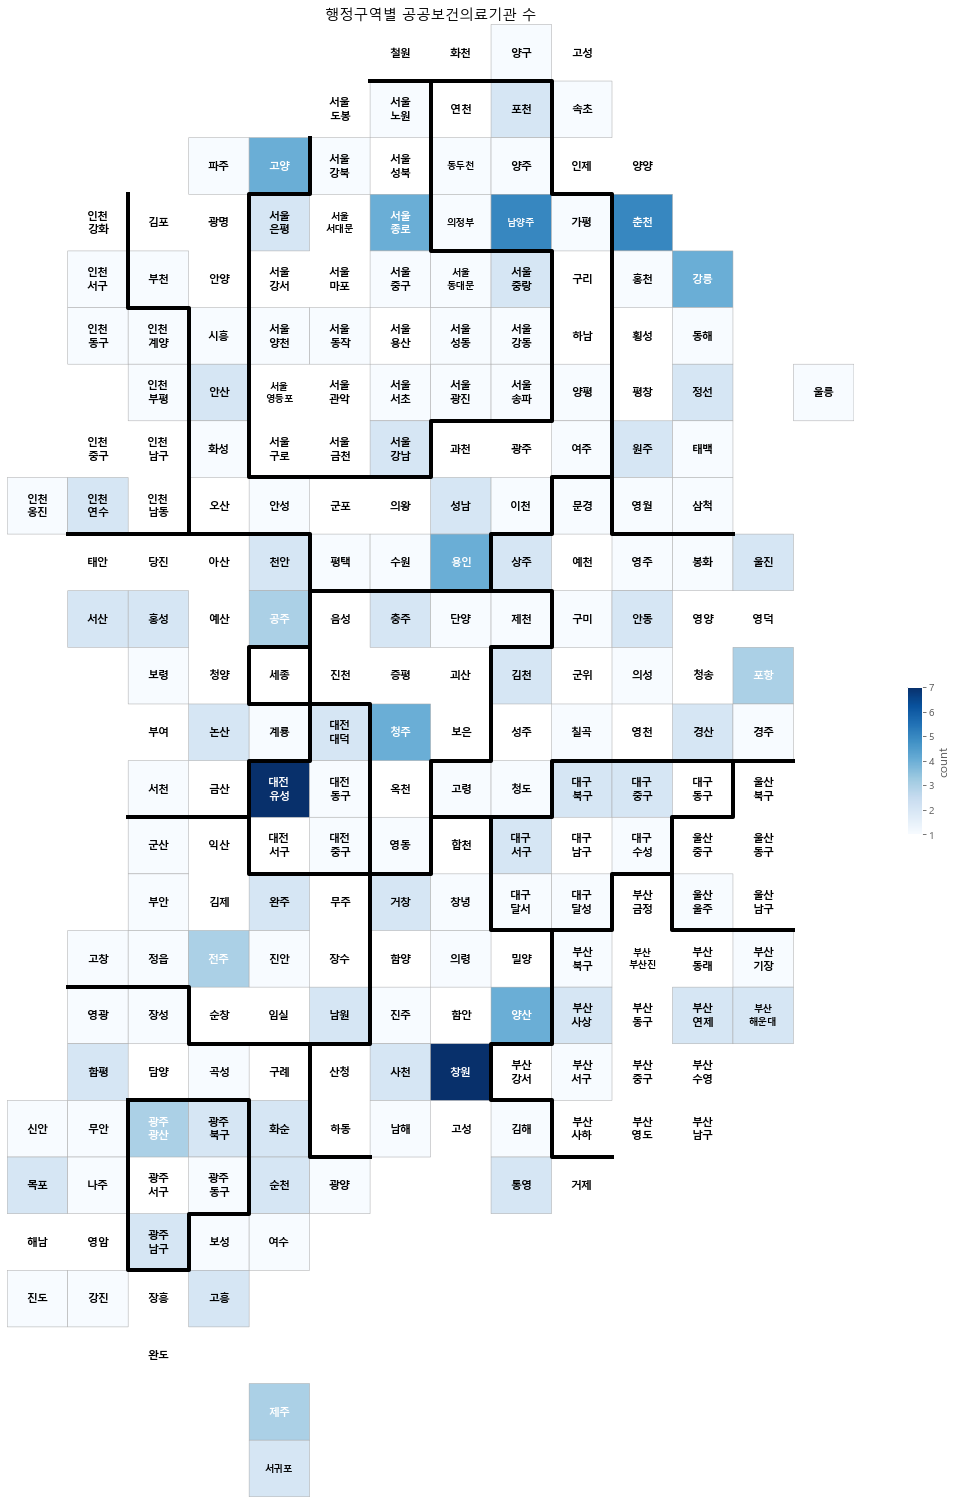

In [61]:
draw_blockMap(data_draw_korea_MC_Population_all, 'count', '행정구역별 공공보건의료기관 수', 'Blues')

#####     - 행정구역별 인구에 대한 의료기관 비율에 대한 블록맵

C:\Users\hsg55\AppData\Local\Temp\ipykernel_9024\1811588993.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=color, edgecolor='#aaaaaa', linewidth=0.5)
C:\Users\hsg55\AppData\Local\Temp\ipykernel_9024\1811588993.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(shrink=.1, aspect=10)


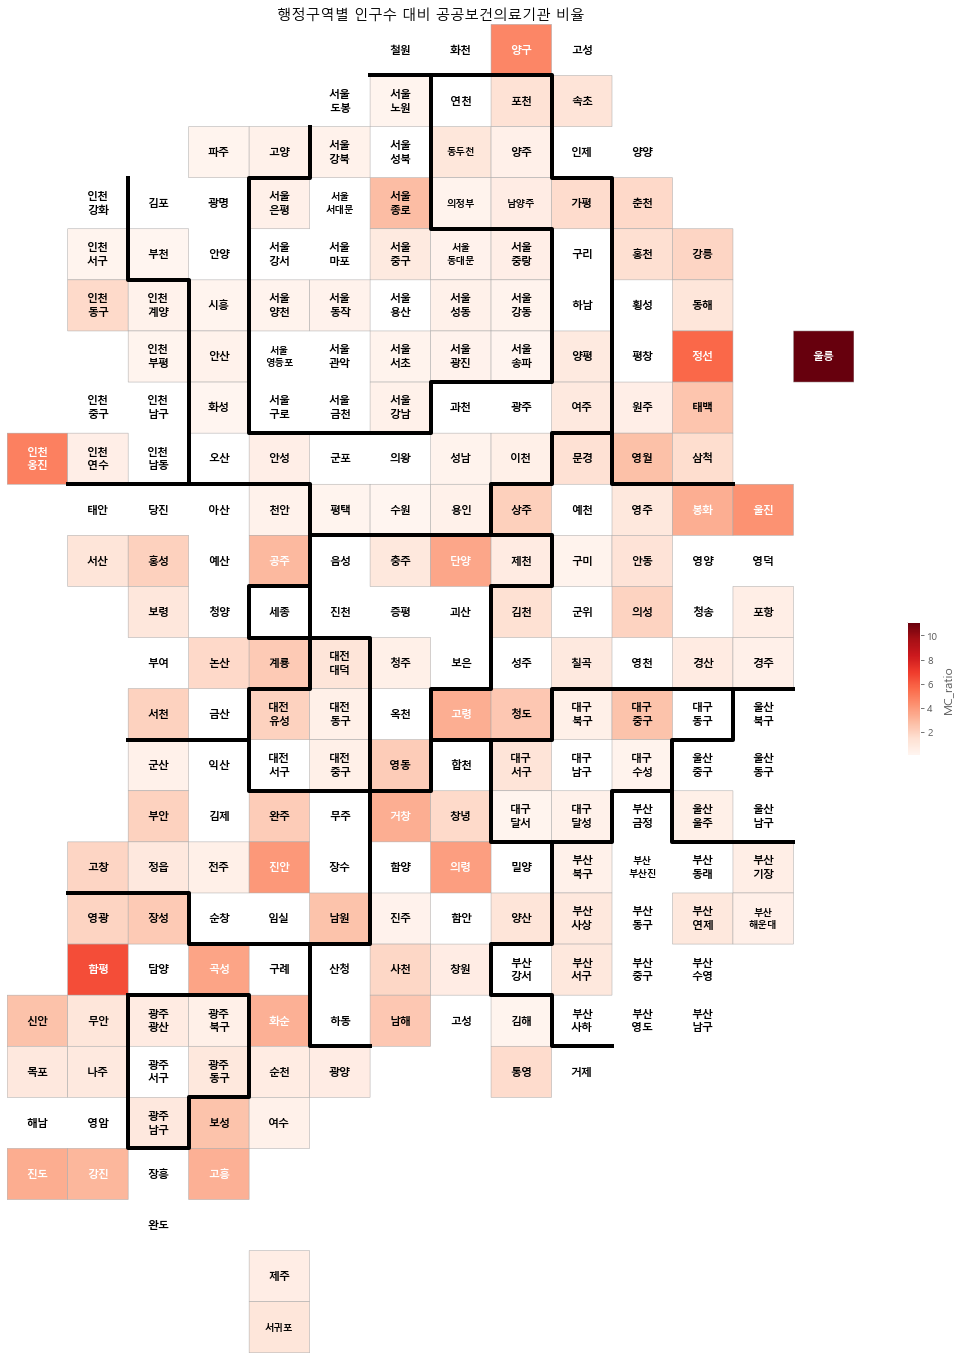

In [51]:
draw_blockMap(data_draw_korea_MC_Population_all, 'MC_ratio', '행정구역별 인구수 대비 공공보건의료기관 비율', 
              'Reds' )